## 🌐 **Google Drive and Kaggle Connection**

In [2]:
# Install and configure Kaggle API
!pip install -q kaggle

import os
from google.colab import drive
from google.colab import files

# --- Configuration ---
# Percorso di destinazione sul Drive
DRIVE_MOUNT_PATH = "/content/gdrive"
DATASET_PATH = f"{DRIVE_MOUNT_PATH}/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset"
COMPETITION_ID = "an2dl2526c2"
ZIP_FILENAME = f"{COMPETITION_ID}.zip"
EXPECTED_ZIP_FILE = os.path.join(DATASET_PATH, ZIP_FILENAME)

# --- 1. Mount Google Drive ---
print("1. Mounting Google Drive...")
# Mount G-Drive if it's not already mounted
if not os.path.exists(DRIVE_MOUNT_PATH):
    drive.mount(DRIVE_MOUNT_PATH)
else:
    print("Drive already mounted.")

# --- 2. Check for Existing Data ---
if os.path.exists(EXPECTED_ZIP_FILE):
    print(f"\n✅ Dataset found at {DATASET_PATH}. Skipping download and setup.")
    # You can also add a check here for the unzipped folders if you prefer.
else:
    # --- 3. Setup Kaggle Credentials (Only if download is needed) ---
    print("\n⏳ Dataset not found. Starting Kaggle setup and download.")

    # 3a. Upload kaggle.json
    print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")

    # Check if files.upload() returned a file (if running interactively)
    # The uploaded dictionary keys are the filenames.
    uploaded = files.upload()

    if "kaggle.json" in uploaded:
        # 3b. Configura le credenziali
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle credentials configured.")

        # 3c. Create destination folder and Download
        !mkdir -p {DATASET_PATH}
        print(f"Downloading dataset to: {DATASET_PATH}")
        # Scarica il dataset direttamente da Kaggle nella cartella scelta
        !kaggle competitions download -c {COMPETITION_ID} -p {DATASET_PATH}

    else:
        print("\n⚠️ kaggle.json not uploaded. Cannot proceed with download.")


# --- 4. Decompress Data (Always check for existence before unzipping) ---

EXPECTED_UNZIPPED_FILE = os.path.join(DATASET_PATH, "train_labels.csv")

if os.path.exists(EXPECTED_UNZIPPED_FILE):
    # Check if the key unzipped file is already there
    print(f"\n📦 Data appears to be already unzipped (found: {os.path.basename(EXPECTED_UNZIPPED_FILE)}). Skipping decompression.")

elif os.path.exists(EXPECTED_ZIP_FILE):
    # Only unzip if the zip file is present AND the unzipped files are missing
    print("\n📦 Competition zip found but data not yet extracted. Starting decompression...")

    # -o flag is usually kept for safety, but if you want STRICTLY NO overwrite, you can remove it.
    # For speed optimization, we rely on the outer 'if' block to skip the entire step.
    !unzip -o {EXPECTED_ZIP_FILE} -d {DATASET_PATH}

else:
    # This scenario means neither the zip nor the unzipped files were found.
    # This should only happen if the preceding download step failed or was skipped.
    print("\n⚠️ Cannot decompress: Competition zip file is missing.")

print(f"\nFinal status: Dataset available in: {DATASET_PATH}")

1. Mounting Google Drive...
Mounted at /content/gdrive

✅ Dataset found at /content/gdrive/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset. Skipping download and setup.

📦 Data appears to be already unzipped (found: train_labels.csv). Skipping decompression.

Final status: Dataset available in: /content/gdrive/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import InterpolationMode
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image

# Define the final directories containing the images/masks
# These are the directories created by the unzipping above.
train_img_dir = os.path.join(DATASET_PATH, "train_data")
test_img_dir = os.path.join(DATASET_PATH, "test_data")
labels_file = os.path.join(DATASET_PATH, "train_labels.csv")

# --- Load Labels and Map Classes ---

# Load the labels file
labels_df = pd.read_csv(labels_file)

# The classes are string labels (e.g., 'HER2(+)', 'Luminal B'). We need to map them to integers.
# This also ensures we get the ordered list of class names.
le = LabelEncoder()
labels_df['label_encoded'] = le.fit_transform(labels_df['label'])

# Store the class names and mapping
class_names = list(le.classes_)
num_classes = len(class_names)
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"\nFound {len(labels_df)} training samples.")
print(f"Number of classes: {num_classes}")
print(f"Class Names: {class_names}")
print(f"Label Mapping: {class_mapping}")

# --- Create a Validation Split ---

# Split the training data into training and validation sets (e.g., 90/10 split)
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.1,  # 10% for validation (about 141 images)
    stratify=labels_df['label'], # Important: Stratify to maintain class balance
    random_state=SEED
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")




Found 1412 training samples.
Number of classes: 4
Class Names: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Label Mapping: {'HER2(+)': np.int64(0), 'Luminal A': np.int64(1), 'Luminal B': np.int64(2), 'Triple negative': np.int64(3)}
Training set size: 1270
Validation set size: 142


In [6]:
class HistologyDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset for AN2DL Histology Images."""

    def __init__(self, df, img_dir, mask_dir=None, transform=None):
        """
        Args:
            df: pandas DataFrame with 'sample_index' (filename) and 'label_encoded'.
            img_dir: Path to the directory containing the image files.
            mask_dir: Optional path to the directory containing the mask files.
            transform: Transformations to apply to the image (including normalization).
        """
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # We also need a transform to convert PIL Image to Tensor *before* augmentation,
        # but since we incorporated transforms.ToImage() and ToDtype() into our pipelines,
        # we can handle it there, provided the transform pipeline starts with the PIL image.

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get sample info
        row = self.df.iloc[idx]
        img_id = row['sample_index']
        label = row['label_encoded']

        # 1. Load Image (Always load as PIL image first)
        img_path = os.path.join(self.img_dir, f"{img_id}")
        # Use .convert("RGB") to ensure all images are 3-channel, even if they appear grayscale
        image = Image.open(img_path).convert("RGB")

        # 2. (Optional) Load Mask - This is a possible extension for later
        # If using masks, you would load them here and decide how to integrate them

        # 3. Apply Transforms (including conversion to tensor and normalization)
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # Fallback transform if none is provided
            image_tensor = transforms.ToTensor()(image)

        # Return the image tensor and the encoded label
        return image_tensor, label

## 🔎 **Data Exploration**

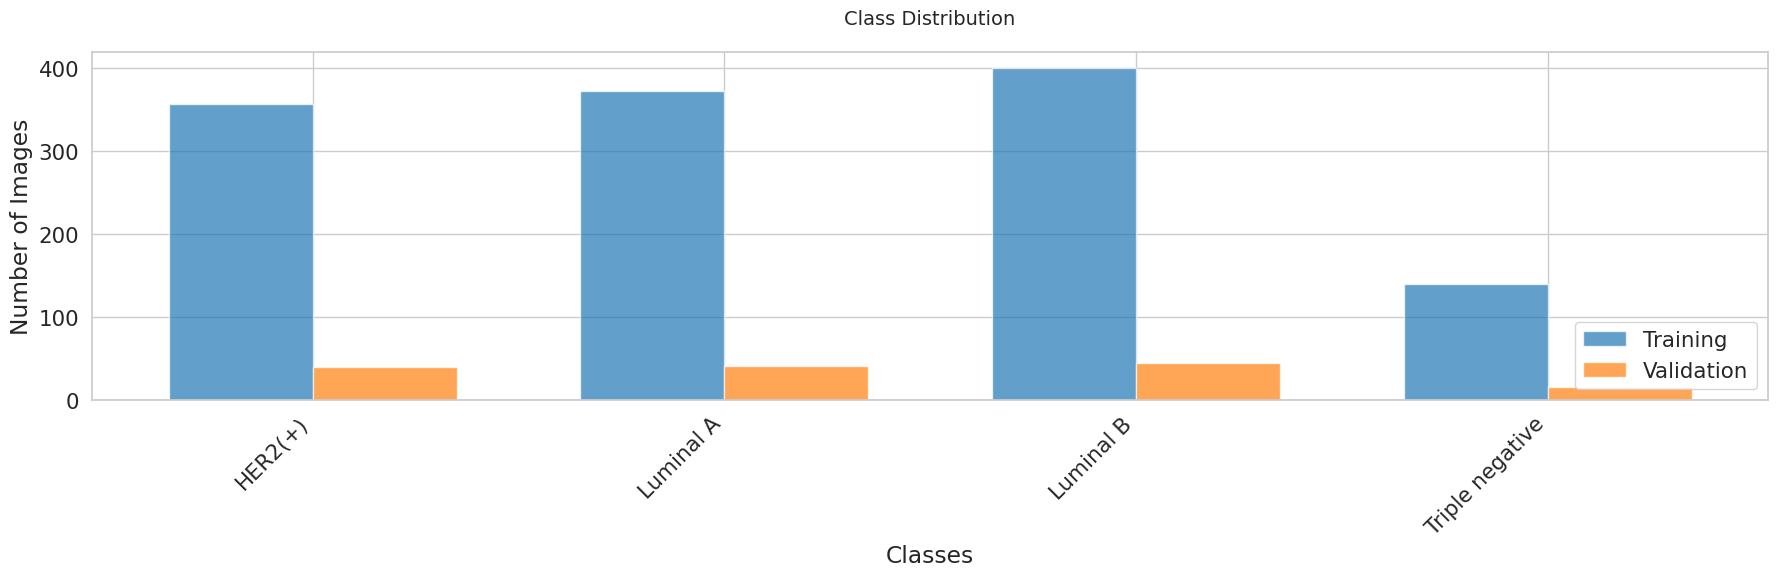

In [7]:
# plot Training vs. Validation
def plot_train_val_distribution(y_train_encoded, y_val_encoded, class_names):
    """Plot class distribution for training and test sets."""
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and val sets
    train_dist = np.bincount(y_train_encoded)
    test_dist = np.bincount(y_val_encoded)

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#1f77b4', alpha=0.7)
    plt.bar(x + width / 2, test_dist, width, label='Validation', color='#ff7f0e', alpha=0.7)

    # Customize plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_train_val_distribution(train_df['label_encoded'].values, val_df['label_encoded'].values, class_names)

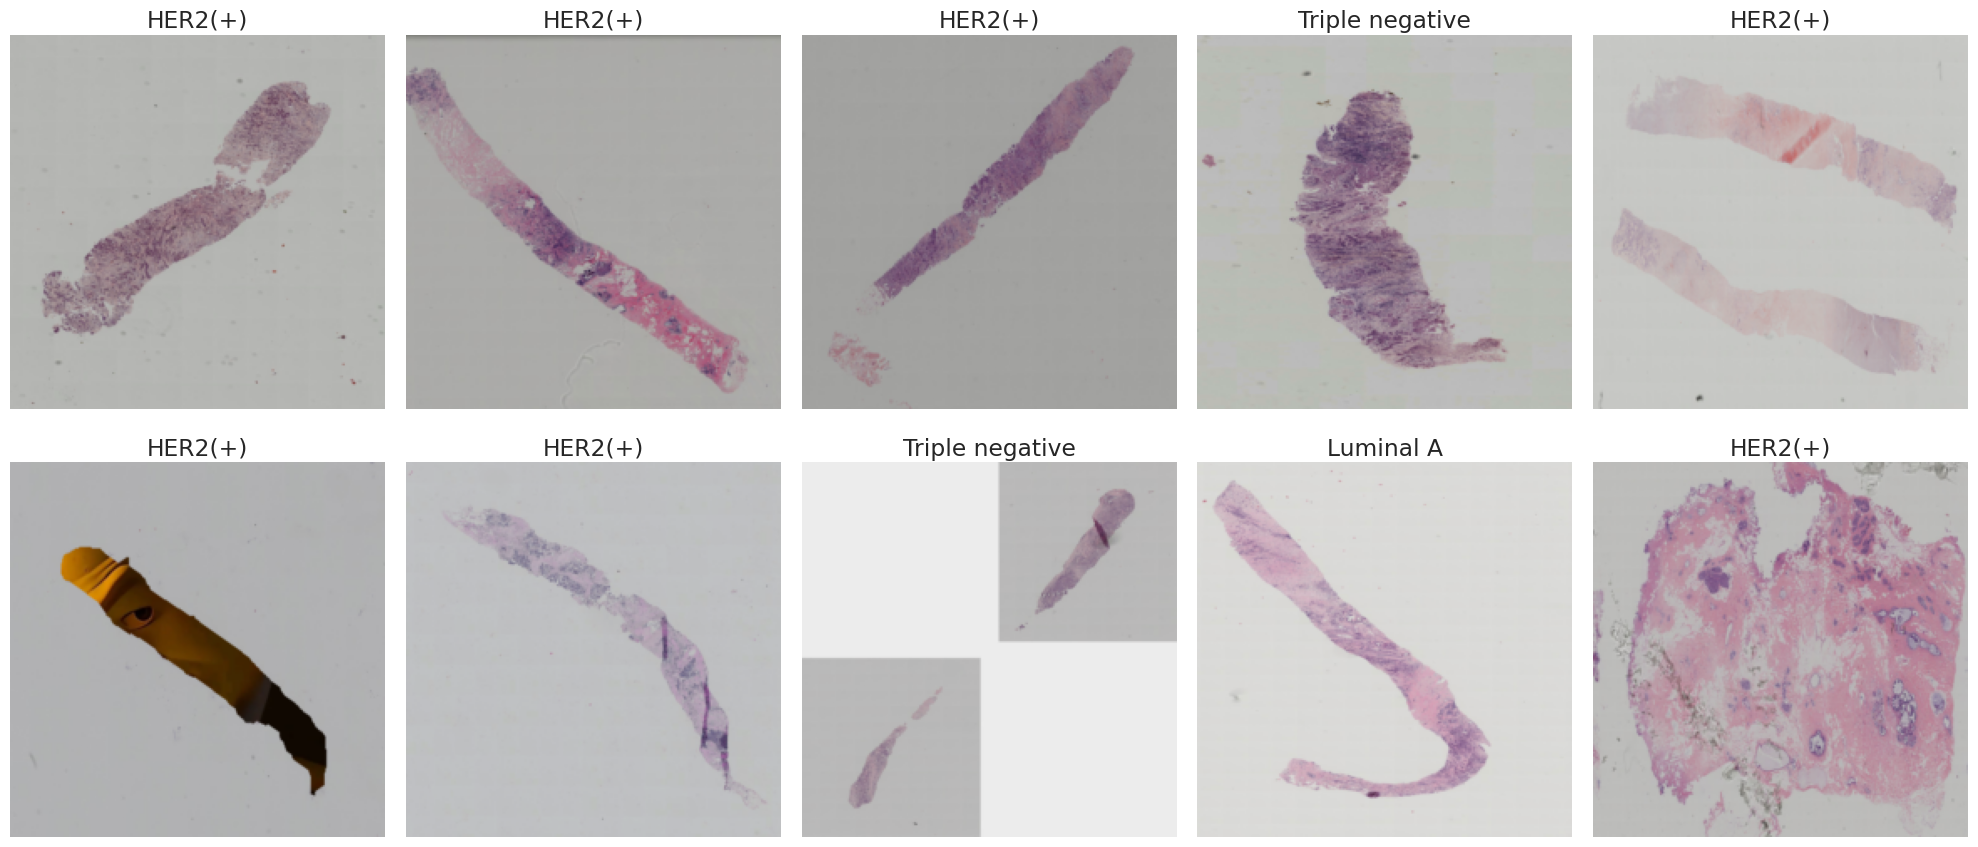

In [8]:
# Create temporary dataset and dataloader to fetch some samples
temp_dataset = HistologyDataset(
    df=train_df,
    img_dir=train_img_dir,
    # Add your chosen transformation here, e.g., only resize/normalize
    transform=transforms.Compose([
        transforms.ToImage(),
        transforms.Resize((224, 224), antialias=True),
        transforms.ToDtype(torch.float32, scale=True)
    ])
)

# Fetch a few samples from the dataset manually (or use a DataLoader)
num_img = 10
random_indices = random.sample(range(len(temp_dataset)), num_img)

fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Get the image and label tensor
    img_tensor, label_encoded = temp_dataset[idx]

    # Display the image (convert C H W to H W C, and un-normalize if necessary)
    # The default ToDtype(..., scale=True) results in [0, 1] range.
    img_array = img_tensor.permute(1, 2, 0).numpy()
    ax.imshow(img_array)

    # Add class name as title
    class_name = class_names[label_encoded]
    ax.set_title(class_name, pad=5)

    ax.axis('off')

plt.tight_layout()
plt.show()

##  📄 **Data Preprocessing**

In [9]:
# --- Constants and Configuration ---

# Define the batch size
BATCH_SIZE = 32 # Start with 32 or 64, depending on your GPU memory

# ImageNet normalization statistics
# These are standard statistics used when working with models pre-trained on ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Target image size: WSI patches are large, 224x224 or 384x384 are common for transfer learning.
# Start with 224 for standard ResNet/VGG models.
TARGET_SIZE = 224

# Define the input shape and number of classes
input_shape = (3, TARGET_SIZE, TARGET_SIZE)
# Use the variables determined in your setup code:
# num_classes = len(class_names)

print(f"Input Shape: {input_shape}")
print(f"Number of Classes: {num_classes}")

# --- Core Transformations for Validation/Test ---

# These transformations apply to validation and test data: resizing and normalization.
# Augmentations are NOT applied to validation/test sets.
core_transforms = transforms.Compose([
    # Convert PIL Image to PyTorch Tensor in [0, 1] range
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),

    # Resize the image to a consistent size (important for CNNs)
    transforms.Resize((TARGET_SIZE, TARGET_SIZE), antialias=True),

    # Apply ImageNet normalization (crucial for transfer learning)
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# --- Training Augmentation Pipeline ---
# Define the augmentation transforms for the training set only.
train_augmentation = transforms.Compose([
    # First, apply the core transforms like Resize and convert to Tensor [0, 1]
    core_transforms,

    # Augmentations (applied *after* conversion to tensor)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),

    # Note: Normalization is included in core_transforms, so it happens here last.
])

Input Shape: (3, 224, 224)
Number of Classes: 4


In [10]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """Create a PyTorch DataLoader with optimized settings."""
    # cpu_cores = os.cpu_count() or 2
    # Setting num_workers to 2 or 4 is usually a good starting point in Colab
    num_workers = 2

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True, # Accelerates transfer to GPU
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4, # Load more batches in advance
    )

# --- Instantiate Datasets ---

# 1. Training Dataset (with augmentation)
train_dataset = HistologyDataset(
    df=train_df,
    img_dir=train_img_dir,
    transform=train_augmentation # Use the augmentation pipeline
)

# 2. Validation Dataset (no augmentation)
val_dataset = HistologyDataset(
    df=val_df,
    img_dir=train_img_dir, # Validation data is split from the training files
    transform=core_transforms # Use core transforms (resize, normalize) only
)

# 3. Test Dataset (for final submission prediction)
# NOTE: The test set has NO LABELS (it's for prediction only), so we use a dummy column.
test_df = pd.DataFrame({'sample_index': os.listdir(test_img_dir)})
test_dataset = HistologyDataset(
    df=test_df,
    img_dir=test_img_dir,
    transform=core_transforms # Use core transforms only
)


# --- Instantiate DataLoaders ---

train_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = make_loader(val_dataset, BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_dataset, BATCH_SIZE, shuffle=False, drop_last=False)


# --- Final Check of Loader Sizes ---
print("\n--- Final Dataset and Loader Sizes ---")
print(f"Train Dataset size: {len(train_dataset)} samples")
print(f"Validation Dataset size: {len(val_dataset)} samples")
print(f"Test Dataset size: {len(test_dataset)} samples")
print(f"Train Loader has: {len(train_loader)} batches (batch size: {BATCH_SIZE})")
print(f"Validation Loader has: {len(val_loader)} batches (batch size: {BATCH_SIZE})")
print(f"Test Loader has: {len(test_loader)} batches (batch size: {BATCH_SIZE})")

# Example of fetching a batch:
# images, labels = next(iter(train_loader))
# print(f"\nExample batch shape (images): {images.shape}")
# print(f"Example batch shape (labels): {labels.shape}")


--- Final Dataset and Loader Sizes ---
Train Dataset size: 1270 samples
Validation Dataset size: 142 samples
Test Dataset size: 1908 samples
Train Loader has: 39 batches (batch size: 32)
Validation Loader has: 5 batches (batch size: 32)
Test Loader has: 60 batches (batch size: 32)


##  🧮 **Network Parameters**

In [11]:
# Training parameters
LEARNING_RATE = 1e-3
EPOCHS = 200
PATIENCE = 20

# Regularization
DROPOUT_RATE = 0.3

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 200
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.3
Patience: 20


##  🧠 **Training Functions**

In [12]:
from sklearn.metrics import accuracy_score, f1_score # Ensure f1_score is imported

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # Automatic Mixed Precision (AMP) block for efficient CUDA utilization
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        # Scale the loss, backpropagate, and update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc

In [13]:
def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch, calculating loss, accuracy, and F1-Score."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # AMP block
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(y_true, y_pred)

    # Competition Metric: Calculate the Macro F1-Score
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_accuracy, epoch_f1

In [14]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=PATIENCE, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """
    Train the neural network model.
    Evaluation Metric is set to 'val_f1' by default for the competition.
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': [] # Added F1-Score tracking
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        # --- Training Step ---
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        # --- Validation Step ---
        # Capture the new F1-Score return value
        val_loss, val_acc, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # --- Update History ---
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['val_f1'].append(val_f1) # Record F1-Score

        # --- TensorBoard Logging ---
        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)
            writer.add_scalar('F1-Score/Validation', val_f1, epoch) # Log F1-Score

        # --- Console Output ---
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                      f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        # --- Early Stopping Logic ---
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                # Save the model state dict
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs (no improvement in {evaluation_metric} for {patience} epochs).")
                    break

    # --- Final Actions ---
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        # Save the final model if no early stopping was used
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

## 🛠️ **Transfer Learning**

In [22]:
# --- Configuration ---
# You can change 'resnet50' to 'mobilenet_v3_small' or 'densenet121' later.
MODEL_BACKBONE = 'mobilenet_v3_small'
DROPOUT_RATE = 0.3 # Use your defined parameter
FREEZE_BACKBONE = True # Start with freezing, then fine-tune later

In [23]:
class MobileNetV3TransferLearning(nn.Module):
    """
    MobileNetV3Small with pretrained weights for transfer learning.

    IMPORTANT: This model expects ImageNet-normalized inputs!
    Images should be normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
    """

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # MobileNetV3Small backbone with ImageNet pretrained weights
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace classifier (always trainable)
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.Hardswish(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [25]:
# Create transfer learning model
tl_model = MobileNetV3TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE,
).to(device)

print(f"Model created: {MODEL_BACKBONE} (Backbone frozen: {FREEZE_BACKBONE})")

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

Model created: mobilenet_v3_small (Backbone frozen: True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 5

Model created: mobilenet_v3_small (Backbone frozen: True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 5

In [26]:
# --- Setup Training ---
# Note: Ensure train_loader, val_loader, criterion, and the constant BATCH_SIZE
# are defined in the cells above.

experiment_name = f"tl_{MODEL_BACKBONE}_{'frozen' if FREEZE_BACKBONE else 'finetune'}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# Optimizer: Only optimize trainable parameters (the new classification head)
# If freeze_backbone=False, all parameters will be optimized.
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")

# %%time (Use this magic command in your notebook cell)
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader, # Use the global loader defined earlier
    val_loader=val_loader,     # Use the global loader defined earlier
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1' # Prioritize the competition metric
)


Starting training for experiment: tl_mobilenet_v3_small_frozen
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3178, Acc=0.3149 | Val: Loss=1.2945, Acc=0.3521, F1=0.2321
Epoch   5/200 | Train: Loss=1.2055, Acc=0.4143 | Val: Loss=nan, Acc=0.2817, F1=0.1099
Epoch  10/200 | Train: Loss=1.1735, Acc=0.4447 | Val: Loss=nan, Acc=0.2817, F1=0.1099


KeyboardInterrupt: 

In [ ]:
# --- Evaluation and Plotting ---

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
print(f'\nFinal best validation F1-Score: {final_val_f1}%')


# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='blue', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='blue')
ax1.set_title(f'{experiment_name} - Loss (Categorical Crossentropy)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of validation F1-Score (The COMPETITION METRIC) and Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='orange', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='orange')
# F1-Score on a secondary axis (optional, but informative)
ax2_f1 = ax2.twinx()
ax2_f1.plot(tl_history['val_f1'], label='Validation F1-Score', alpha=0.9, color='green', linewidth=2)
ax2_f1.set_ylabel('F1-Score (Macro)', color='green')
ax2_f1.tick_params(axis='y', labelcolor='green')

ax2.set_title(f'{experiment_name} - Metrics (Acc & F1-Score)')
ax2.legend(loc='lower left')
ax2_f1.legend(loc='upper right')
ax2.grid(alpha=0.3)


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
###TODO: FIX

class GenericTransferLearning(nn.Module):
    """
    Generic PyTorch model using a pre-trained ImageNet backbone (default: ResNet-50).

    IMPORTANT: This model expects ImageNet-normalized inputs!
    """

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True, model_name='mobilenet_v3_small'):
        super().__init__()

        # Select backbone model based on name
        if model_name == 'resnet50':
            self.backbone = torchvision.models.resnet50(
                weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
            )
            # ResNet replaces the final fully connected layer (fc)
            in_features = self.backbone.fc.in_features

        elif model_name == 'mobilenet_v3_small':
            self.backbone = torchvision.models.mobilenet_v3_small(
                weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
            )
            # MobileNet replaces the classifier (nn.Sequential)
            in_features = self.backbone.classifier[0].in_features
            self.backbone.fc = self.backbone.classifier # Temporarily unify access

        else:
            raise ValueError(f"Model {model_name} not supported.")

        # Freeze backbone parameters if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace the final classification head (the only part that is always trained)
        self.backbone.fc = nn.Sequential(
            # nn.Linear(in_features, in_features // 2), # Optional intermediate layer
            # nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )
        # Ensure the new classification head parameters are trainable
        for param in self.backbone.fc.parameters():
            param.requires_grad = True


    def forward(self, x):
        # We need a slight modification for MobileNetV3 to match ResNet's output attribute name
        if hasattr(self.backbone, 'classifier'):
             # If using MobileNetV3, we use the custom forward behavior built in torchvision
             return self.backbone(x)
        else:
             # Standard forward for ResNet, etc.
             return self.backbone(x)


# --- Configuration ---
# You can change 'resnet50' to 'mobilenet_v3_small' or 'densenet121' later.
MODEL_BACKBONE = 'mobilenet_v3_small'
DROPOUT_RATE = 0.3 # Use your defined parameter
FREEZE_BACKBONE = True # Start with freezing, then fine-tune later

# Create transfer learning model
tl_model = GenericTransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE,
    model_name=MODEL_BACKBONE
).to(device)

print(f"Model created: {MODEL_BACKBONE} (Backbone frozen: {FREEZE_BACKBONE})")

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph